In [66]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
df = pd.read_csv('alldata_unstandard.csv')

In [6]:
def autoregressor(df):
    """
    Gives the x and y vector for the autoregressive model predicting QoL with a 5 year lag

    args:
        - df: dataframe of unstandardized QoL values, country, and year
    
    returns:
        - [X, y]: list of numpy arrays X (X matrix w/ 26 country indicator cols and 5 QoL lag cols)
            and y (y vector w/ last 7 years of QoL scores for each EU country)

    """
    p = 5
    eu_countries = [
                " country_name_Austria", " country_name_Belgium", " country_name_Bulgaria", " country_name_Croatia", " country_name_Cyprus", " country_name_Czechia", " country_name_Denmark",
                " country_name_Estonia", " country_name_Finland", " country_name_France", " country_name_Germany", " country_name_Greece", " country_name_Hungary", " country_name_Ireland",
                " country_name_Italy", " country_name_Latvia", " country_name_Lithuania", " country_name_Luxembourg", " country_name_Malta", " country_name_Netherlands",
                " country_name_Poland", " country_name_Portugal", " country_name_Romania", " country_name_Slovakia", " country_name_Slovenia", " country_name_Spain"
            ]

    df_encoded = pd.get_dummies(df, columns=[' country_name'], dtype = 'int')

    X = []
    y = []

    for country in df[' country_name'].unique(): 

        mask = df[' country_name'] == country
        df_country = df_encoded[mask].sort_values(' score_year')

        qol_country = df_country[' qol_score'].to_numpy()
        dummy_country = df_country[eu_countries].to_numpy()[0]

        for t in range(p, len(qol_country)):
            lags = qol_country[t - p:t][::-1] 
            
            row = np.concatenate([dummy_country, lags])
            X.append(row)
            y.append(qol_country[t])

    X = np.array(X)
    y = np.array(y)

    return [X, y]

In [7]:
def linreg(X, y):
    """
    Returns weight vector for autoregressive model

    args: 
        - X: X matrix w/ 26 country indicator cols and 5 QoL lag cols
        - y: y vector w/ last 7 years of QoL scores for each EU country

    returns: 
        - w: weight vector 
    """
    XtXinv = np.linalg.inv(np.matmul(X.T, X))
    w = np.matmul(XtXinv, np.matmul(X.T, y))

    return w

In [ ]:
def predict(y, w, country, target_year):
    """
    Predicts future QoL for a given country and year

    args:
        - y: y vector w/ last 7 years of QoL scores for each EU country
        - w: weight vector
        - country: string country name
        - target_year: numerical year to predict for

    returns: 
        - pred: prediction for QoL for given country and year
    """
    country_list = [
                "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark",
                "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland",
                "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands",
                "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
            ]
    values_per_country = 7
    p = 5

    # creating one-hot encoding columns
    if country == "Sweden":
        startX = np.zeros(len(country_list) - 1)
    else:
        country_index = country_list.index(country)
        startX = np.zeros(len(country_list) - 1)
        startX[country_index] = 1

    base_index = country_list.index(country)  
    start = base_index * values_per_country 
    end = start + 5
    endY = y[start:end][::-1].tolist()

    current_year = 2023
    
    while current_year <= target_year:
        row = np.concatenate([startX, endY])
        X = np.array(row)
        pred = np.dot(X, w)
        endY = [pred] + endY[:p - 1]  
        current_year += 1

    return pred

In [9]:
def prediction_table(country):
    """
    Predicts QoL score for next five years and returns a dataframe of year and predicted QoL score

    args:
        - country: string target country name

    returns: 
        - pred_df: dataframe of next five years of QoL scores for inputted country
    """
    matrices = autoregressor(df)
    X = matrices[0]
    y = matrices[1]
    w = linreg(X, y)
    years = list(range(2023, 2028))  
    predictions = []

    for year in years:
        pred = predict(y, w, country, year)
        predictions.append({'year': year, 'predictions': pred})

    pred_df = pd.DataFrame(predictions)       

    return pred_df

In [10]:
def qol_df(old_df, pred_df, country):
    """
    Creates a dataframe with existing and predicted QoL scores for a particular country.
    Returns a single column 'qol_score' with an indicator 'predicted'
    """
    actual = old_df[old_df[" country_name"] == country][[" score_year", " qol_score"]].copy()
    actual.columns = ["year", "qol_score"]
    actual["Projected?"] = "Historical Score"

    predicted = pred_df.copy()
    predicted.columns = ["year", "qol_score"]
    predicted["Projected?"] = "Projected Score"

    merged = pd.concat([actual, predicted], ignore_index=True)
    merged = merged.sort_values("year").reset_index(drop=True)

    return merged


In [11]:
def plot_qol(qol_data, country):
    """
    Plots actual and predicted QoL scores over time for a single country
    
    Args:
        - qol_data: DataFrame with 'year', 'qol_score', and 'Projected?'
        - country: Name of the country (str)
    """  
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=qol_data['year'],
        y=qol_data['qol_score'],
        mode='lines+markers',
        name='QoL Score',
        line=dict(color='royalblue'),
        customdata=qol_data[['Projected?']], 
        hovertemplate=
            'Year: %{x}<br>' +
            'QoL Score: %{y:.3f}<br>' +
            'Projected?: %{customdata[0]}<extra></extra>'
    ))

    fig.add_vline(x=2022.5, line_width=2, line_dash="dash", line_color="gray")

    fig.add_vrect(
        x0=2023, x1=qol_data['year'].max(),
        fillcolor="lightgray", opacity=0.3,
        layer="below", line_width=0,
        annotation_text="Predicted", annotation_position="top left"
    )

    fig.update_layout(
        title= f"Quality of Life (Historical and Projected) for {country}",
        xaxis_title="Year",
        yaxis_title="Quality of Life Score",
        hovermode="x unified"
    )

    fig.show()

In [12]:
matrices = autoregressor(df)
X = matrices[0]
y = matrices[1]
w = linreg(X,y)

In [13]:
test = prediction_table("Austria")
test1 = qol_df(df, test, "Austria")
plot_qol(test1, "Austria")

In [73]:
def training(df, country):
    """
    Gives the x and y vector for the autoregressive model predicting QoL with a 5 year lag for the training set

    args:
        - df: dataframe of unstandardized QoL values, country, and year
        - country: country to cross val
    
    returns:
        - X: X matrix for training set
        - y: y vector for training set
        - w: weight vector for training set

    """
    p = 5
    eu_countries = [
        " country_name_Austria", " country_name_Belgium", " country_name_Bulgaria", " country_name_Croatia",
        " country_name_Cyprus", " country_name_Czechia", " country_name_Denmark",
        " country_name_Estonia", " country_name_Finland", " country_name_France", " country_name_Germany",
        " country_name_Greece", " country_name_Hungary", " country_name_Ireland",
        " country_name_Italy", " country_name_Latvia", " country_name_Lithuania", " country_name_Luxembourg",
        " country_name_Malta", " country_name_Netherlands",
        " country_name_Poland", " country_name_Portugal", " country_name_Romania",
        " country_name_Slovakia", " country_name_Slovenia", " country_name_Spain"
    ]  

    df_filtered = df[(df[' score_year'] >= 2011) & (df[' score_year'] <= 2020) & (df[' country_name'] == country)]

    df_encoded = pd.get_dummies(df, columns=[' country_name'], dtype='int')

    X = []
    y = []

    dummy_vector = np.zeros(len(eu_countries))
    dummy_col_names = eu_countries
    
    country_col_name = " country_name_" + country
    if country_col_name in dummy_col_names:
        idx = dummy_col_names.index(country_col_name)
        dummy_vector[idx] = 1
    else:
        pass

    qol_series = df_filtered.sort_values(' score_year')[' qol_score'].to_numpy()

    for t in range(p, len(qol_series)):
        lags = qol_series[t - p:t][::-1]  
        row = np.concatenate([dummy_vector, lags])
        X.append(row)
        y.append(qol_series[t])

    X = np.array(X)
    y = np.array(y)

    XtXinv = np.linalg.pinv(np.matmul(X.T, X))
    w = np.matmul(XtXinv, np.matmul(X.T, y))   

    return w

In [74]:
def testing(df, country, w, p=5):
    eu_countries = [
        "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark",
        "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland",
        "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands",
        "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain"
    ]

    if country == "Sweden":
        startX = np.zeros(len(eu_countries))
    else:
        country_index = eu_countries.index(country)
        startX = np.zeros(len(eu_countries))
        startX[country_index] = 1

    df_country = df[df[" country_name"] == country]

    qol = df_country[" qol_score"].to_numpy()
    years = df_country[" score_year"].to_list()

    idx_2021 = years.index(2021)
    idx_2022 = years.index(2022)
    
    X_test = []

    lag_2021 = qol[idx_2021 - p:idx_2021][::-1]
    row_2021 = np.concatenate([startX, lag_2021])
    X_test.append(row_2021)

    lag_2022 = qol[idx_2022 - p:idx_2022][::-1]
    row_2022 = np.concatenate([startX, lag_2022])
    X_test.append(row_2022)

    X_test = np.array(X_test)

    # Predict
    y_preds = np.dot(X_test, w)

    # True values for 2021 and 2022 QoL (actual)
    y_true = np.array([qol[idx_2021], qol[idx_2022]])

    # Calculate MSE and R2
    mse = mean_squared_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)

    print(f"Predictions: {y_preds}")
    print(f"True values: {y_true}")
    print(f"MSE: {mse}")
    print(f"R2: {r2}")

    return y_preds, mse, r2


In [75]:
w_train = training(df, "Austria")
test = testing(df, "Austria", w_train)
print(test)


Predictions: [7.0206319  7.00636728]
True values: [7.163 7.097]
MSE: 0.014241482531275263
R2: -12.077578081979187
(array([7.0206319 , 7.00636728]), 0.014241482531275263, -12.077578081979187)


In [83]:
y_preds = X @ w
resids = y - y_preds
pre_cv_r2 = r2_score(y, y_preds)
pre_cv_mse = mean_squared_error(y, y_preds)

lag_index = int(input())

lag_col = 26 + lag_index - 1  
x_feature = [x[lag_col] for x in X]

print(f"Pre-CV R2: {pre_cv_r2}")
print(f"Pre-CV MSE: {pre_cv_mse}")


Pre-CV R2: 0.986336635437033
Pre-CV MSE: 0.006365779232668976


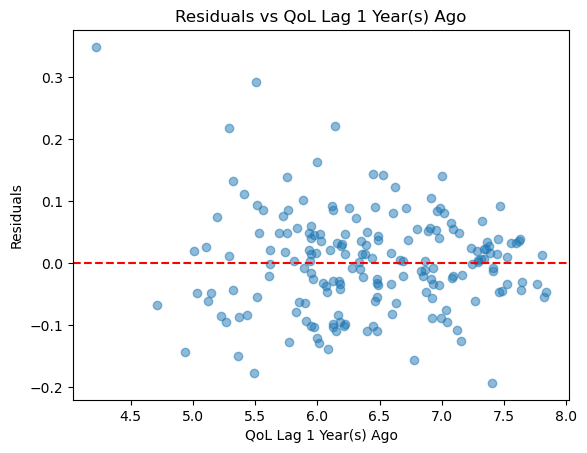

In [79]:
# resids vs. x vals
plt.scatter(x_feature, resids, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel(f'QoL Lag {lag_index} Year(s) Ago')
plt.ylabel('Residuals')
plt.title(f'Residuals vs QoL Lag {lag_index} Year(s) Ago')
plt.show()

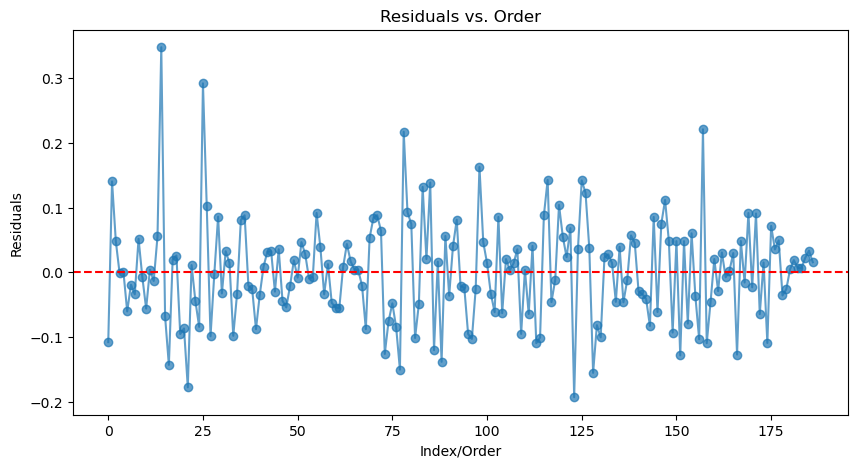

In [80]:

# reisds vs. order
plt.figure(figsize=(10, 5))
plt.plot(resids, marker='o', linestyle='-', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Index/Order')
plt.ylabel('Residuals')
plt.title('Residuals vs. Order')
plt.show()


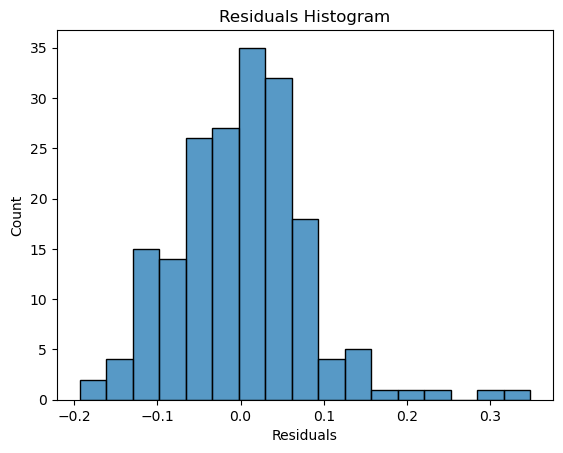

In [81]:

# resids histogram
sns.histplot(resids, kde=False)
plt.xlabel("Residuals")
plt.title("Residuals Histogram")
plt.show()